In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import roc_auc_score
from Vis import plot_loss, plot_roc
from Preprocessing import Preprocessing
from Preprocessing import Cols
import numpy as np
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from pandas import DataFrame
from pandas import Series
import pandas as pd
from keras.layers import Dropout
# pandas.set_option('max_columns',10)

Using TensorFlow backend.


In [2]:
pre = Preprocessing()
X, y = pre.load_data(time_gap=300)

prepared dataset contains: per_stud_dataset + per_action_dataset_summ


In [3]:
per_action_dataset = pre.per_action_dataset
per_action_dataset.index = per_action_dataset.ITEST_id
per_action_dataset = per_action_dataset.drop("ITEST_id", axis=1)
per_action_dataset = per_action_dataset.drop(['assistmentId', 'problemId', 'assignmentId', 'actionId'], axis=1)

In [4]:
# show the seq of a sample student (id =9)
per_action_dataset[per_action_dataset.index.get_level_values(0) ==9].head()

,scaffold,endsWithAutoScaffolding,totalFrSkillOpportunities,responseIsFillIn,frTimeTakenOnScaffolding,sumTimePerSkill,timeGreater5Secprev2wrong,frTotalSkillOpportunitiesScaffolding,startTime,timeOver80,...,RES_CONFUSED,bottomHint,timeTaken,frIsHelpRequestScaffolding,totalFrSkillOpportunitiesByScaffolding,totalFrTimeOnSkill,frIsHelpRequest,consecutiveErrorsInRow,RES_FRUSTRATED,responseIsChosen
ITEST_id,,,,,,,,,,,,,,,,,,,,,
9,0,0,0,0,0.0,15.0,0,0,1131985185,0,...,0.000000,0,15.0,0,0.0,0.000000,1,0,0.000000,0
9,1,0,1,0,96.0,111.0,0,0,1131985200,1,...,0.000000,0,96.0,1,0.0,15.000001,1,0,0.009561,0
9,1,0,2,0,51.0,162.0,0,1,1131985296,0,...,0.000000,0,51.0,1,2.0,111.000000,1,0,0.009561,0
9,1,0,3,0,27.0,189.0,0,2,1131985347,0,...,0.000000,0,27.0,1,1.5,162.000000,1,0,0.009561,0
9,0,0,0,0,0.0,102.0,0,0,1131985374,1,...,0.060808,0,102.0,0,0.0,0.000000,0,0,0.000000,0


In [5]:
#truncating seq of each student and only considering his last 500 actions based on startTime feature
truncated_input = per_action_dataset.sort_values("startTime",ascending=False).groupby('ITEST_id').head(500)

In [6]:
# scaling dataset
scaler = RobustScaler()
X_scaled = scaler.fit_transform(truncated_input)
X_scaled = DataFrame(X_scaled, index=truncated_input.index, columns=truncated_input.columns)
X_scaled[X_scaled.index.get_level_values(0) ==9].head()

,scaffold,endsWithAutoScaffolding,totalFrSkillOpportunities,responseIsFillIn,frTimeTakenOnScaffolding,sumTimePerSkill,timeGreater5Secprev2wrong,frTotalSkillOpportunitiesScaffolding,startTime,timeOver80,...,RES_CONFUSED,bottomHint,timeTaken,frIsHelpRequestScaffolding,totalFrSkillOpportunitiesByScaffolding,totalFrTimeOnSkill,frIsHelpRequest,consecutiveErrorsInRow,RES_FRUSTRATED,responseIsChosen
ITEST_id,,,,,,,,,,,,,,,,,,,,,
9,0.0,0.0,0.000000,0.0,-0.384615,-0.161481,0.0,-0.4,0.799938,0.0,...,0.000000,0.0,1.350106,-1.0,-0.68,-0.048780,0.0,0.0,1.000000,0.0
9,0.0,0.0,-0.222222,0.0,-0.384615,-0.320000,0.0,-0.4,0.799937,0.0,...,0.000000,0.0,0.562227,-1.0,-0.68,-0.268293,0.0,0.0,1.000000,0.0
9,0.0,0.0,-0.444444,0.0,-0.384615,-0.322963,0.0,-0.4,0.799935,0.0,...,0.633474,0.0,-0.165045,-1.0,-0.68,-0.416851,0.0,0.0,68.998276,0.0
9,0.0,0.0,-0.444444,0.0,-0.384615,-0.337778,0.0,-0.4,0.799935,0.0,...,0.000000,0.0,1.925864,-1.0,-0.68,-0.416851,0.0,0.0,1.000000,0.0
9,0.0,0.0,-0.555556,0.0,-0.384615,-0.454815,0.0,-0.4,0.799934,0.0,...,0.060808,0.0,0.501621,-1.0,-0.68,-0.416851,0.0,0.0,0.000000,0.0


In [7]:
# defining sequence length (or number of time-steps) for each student and batch-size
# NOTE that in Keras by default network is updated after each batch and the hidden state is reset after each epoch
batch_size=1
max_length_seq = 500

In [8]:
# padding sequences to have a same length
X_padded = []
for stud_id, stud_seq in X_scaled.groupby(by='ITEST_id'):
    X_padded.append(stud_seq)
X_padded = sequence.pad_sequences(X_padded, max_length_seq, dtype='float64')

In [9]:
pd.set_option('max_columns',90)
# getting a sense about padded dataset
new_seq_ix = pd.Index(list(range(0,max_length_seq))* X_padded.shape[0], name="seq_ix")
ITEST_ix = pd.Index(np.repeat(sorted(X_scaled.index.get_level_values(0).unique()), max_length_seq), name='ITEST_id')
paddedData = DataFrame(X_padded.reshape(X_padded.shape[0]*X_padded.shape[1], -1), index=[ITEST_ix, new_seq_ix], columns=X_scaled.columns)
paddedData[paddedData.index.get_level_values(0) == 27].head()

scaffold  endsWithAutoScaffolding  totalFrSkillOpportunities  \
ITEST_id seq_ix                                                                 
27       0            0.0                      0.0                        0.0   
         1            0.0                      0.0                        0.0   
         2            0.0                      0.0                        0.0   
         3            0.0                      0.0                        0.0   
         4            0.0                      0.0                        0.0   

                 responseIsFillIn  frTimeTakenOnScaffolding  sumTimePerSkill  \
ITEST_id seq_ix                                                                
27       0                    0.0                       0.0              0.0   
         1                    0.0                       0.0              0.0   
         2                    0.0                       0.0              0.0   
         3                    0.0                       0.0              0.0   
         4                    0.0                       0.0              0.0   

                 timeGreater5Secprev2wrong  \
ITEST_id seq_ix                              
27       0                             0.0   
         1                             0.0   
         2                             0.0   
         3                             0.0   
         4                             0.0   

                 frTotalSkillOpportunitiesScaffolding  startTime  timeOver80  \
ITEST_id seq_ix                                                                
27       0                                        0.0        0.0         0.0   
         1                                        0.0        0.0         0.0   
         2                                        0.0        0.0         0.0   
         3                                        0.0        0.0         0.0   
         4                                        0.0        0.0         0.0   

                 hintTotal  helpAccessUnder2Sec  attemptCount  \
ITEST_id seq_ix                                                 
27       0             0.0                  0.0           0.0   
         1             0.0                  0.0           0.0   
         2             0.0                  0.0           0.0   
         3             0.0                  0.0           0.0   
         4             0.0                  0.0           0.0   

                 frPast5WrongCount  original  hintCount  \
ITEST_id seq_ix                                           
27       0                     0.0       0.0        0.0   
         1                     0.0       0.0        0.0   
         2                     0.0       0.0        0.0   
         3                     0.0       0.0        0.0   
         4                     0.0       0.0        0.0   

                 timeGreater10SecAndNextActionRight  sumRight  \
ITEST_id seq_ix                                                 
27       0                                      0.0       0.0   
         1                                      0.0       0.0   
         2                                      0.0       0.0   
         3                                      0.0       0.0   
         4                                      0.0       0.0   

                 RES_CONCENTRATING  frWorkingInSchool  totalFrPastWrongCount  \
ITEST_id seq_ix                                                                
27       0                     0.0                0.0                    0.0   
         1                     0.0                0.0                    0.0   
         2                     0.0                0.0                    0.0   
         3                     0.0                0.0                    0.0   
         4                     0.0                0.0                    0.0   

                 manywrong  RES_BORED  endsWithScaffolding  \
ITEST_id seq_ix                                        

In [10]:
# creating label dataset with index as ITEST_id values
label_dataset = pre.label_dataset[['ITEST_id', 'isSTEM']]
label_dataset.index = label_dataset.ITEST_id
label_dataset = label_dataset.drop("ITEST_id", axis = 1)
label_dataset

,isSTEM
ITEST_id,
9,1
27,0
33,0
35,0
37,0
41,0
77,0
87,0
114,0


In [11]:
# join label with dataset to make sure we have a consistent dataset
# (of course before the training the label column will be droped from data)
X_with_label = paddedData.join(label_dataset)
print(X_with_label.shape)
X_with_label

(233500, 48)


scaffold  endsWithAutoScaffolding  totalFrSkillOpportunities  \
ITEST_id seq_ix                                                                 
9        0            0.0                      0.0                   0.000000   
         1            0.0                      0.0                  -0.222222   
         2            0.0                      0.0                  -0.444444   
         3            0.0                      0.0                  -0.444444   
         4            0.0                      0.0                  -0.555556   
         5            1.0                      0.0                  -0.222222   
         6            1.0                      0.0                  -0.333333   
         7            1.0                      0.0                  -0.333333   
         8            0.0                      0.0                  -0.444444   
         9            0.0                      0.0                  -0.555556   
         10           1.0                      0.0                  -0.333333   
         11           1.0                      0.0                  -0.444444   
         12           1.0                      0.0                  -0.444444   
         13           0.0                      0.0                  -0.444444   
         14           0.0                      0.0                  -0.444444   
         15           0.0                      0.0                  -0.555556   
         16           0.0                      0.0                   1.444444   
         17           0.0                      0.0                   0.333333   
         18           0.0                      0.0                   0.222222   
         19           1.0                      0.0                  -0.222222   
         20           1.0                      0.0                  -0.333333   
         21           1.0                      0.0                  -0.333333   
         22           0.0                      0.0                  -0.333333   
         23           1.0                      0.0                  -0.333333   
         24           1.0                      0.0                  -0.444444   
         25           0.0                      0.0                  -0.555556   
         26           1.0                      0.0                   1.444444   
         27           1.0                      0.0                   1.444444   
         28           1.0                      0.0                   1.333333   
         29           1.0                      0.0                   1.222222   
...                   ...                      ...                        ...   
7782     470          0.0                      0.0                  -0.444444   
         471          0.0                      0.0                  -0.444444   
         472          0.0                      0.0                  -0.444444   
         473          1.0                      0.0                  -0.555556   
         474          0.0                      0.0                  -0.555556   
         475          0.0                      0.0                   0.111111   
         476          0.0                      0.0                   0.111111   
         477          0.0                      0.0                   0.000000   
         478          1.0                      0.0                   0.000000   
         479          1.0                      0.0                   0.000000   
         480          1.0                      0.0                  -0.111111   
         481          1.0                      0.0                  -0.222222   
         482          0.0                      0.0                  -0.111111   
         483          0.0                      0.0                  -0.111111   
         484          1.0                      0.0                  -0.333333   
         485          1.0                      0.0                  -0.222222   
         486          0.0                      0

In [12]:
y_prepared = X_with_label.groupby("ITEST_id").isSTEM.first().values
X_prepared = X_with_label.drop("isSTEM", axis=1)
X_prepared = X_prepared.values.reshape((-1, max_length_seq, X_prepared.shape[1]))
print(X_prepared.shape)
X_prepared

(467, 500, 47)


array([[[   0.        ,    0.        ,    0.        , ...,    0.        ,
            1.        ,    0.        ],
        [   0.        ,    0.        ,   -0.22222222, ...,    0.        ,
            1.        ,    0.        ],
        [   0.        ,    0.        ,   -0.44444444, ...,    0.        ,
           68.9982763 ,    0.        ],
        ..., 
        [   0.        ,    0.        ,   -0.44444444, ...,    2.        ,
          104.58721622,    0.        ],
        [   0.        ,    0.        ,   -0.44444444, ...,    1.        ,
           68.9982763 ,    0.        ],
        [   0.        ,    0.        ,   -0.55555556, ...,    0.        ,
            0.        ,    0.        ]],

       [[   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,    0.        

## Model

In [13]:
def create_LSTM_model(max_length_seq, feature_size):
    # create the LSTM network
    model = Sequential()
    model.add(LSTM(100, input_shape=(max_length_seq, feature_size)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [14]:
# splitting train/test data 
X_train, X_test, y_train,y_test = train_test_split(X_prepared,y_prepared, train_size=.99)

In [15]:
# Create model
model = create_LSTM_model(max_length_seq, X_train.shape[2])
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_split=0.33)

Train on 309 samples, validate on 153 samples
Epoch 1/5
309/309 [==============================] - 246s - loss: 0.5671 - acc: 0.7346 - val_loss: 0.6399 - val_acc: 0.7190
Epoch 2/5
309/309 [==============================] - 250s - loss: 0.5090 - acc: 0.7573 - val_loss: 0.6858 - val_acc: 0.7190
Epoch 3/5
309/309 [==============================] - 246s - loss: 0.4655 - acc: 0.7702 - val_loss: 0.7044 - val_acc: 0.7059
Epoch 4/5
309/309 [==============================] - 244s - loss: 0.4378 - acc: 0.7929 - val_loss: 0.6913 - val_acc: 0.6928
Epoch 5/5
309/309 [==============================] - 243s - loss: 0.3856 - acc: 0.8252 - val_loss: 0.7527 - val_acc: 0.6601


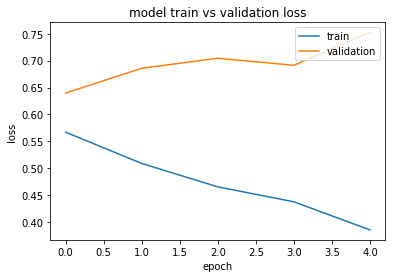

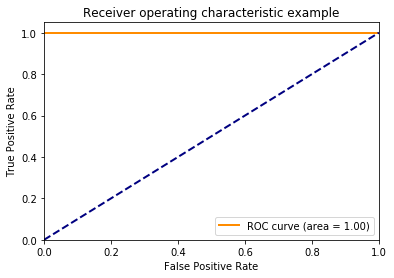

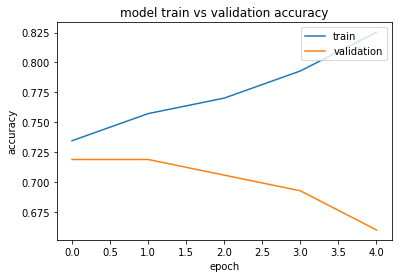

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               59200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 59,301
Trainable params: 59,301
Non-trainable params: 0
_________________________________________________________________
None
Test ROC Score: 1.000000
Test RMSE Score: 0.265609
Final Competition Score: 1.734391


In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from Vis import plot_accuracy
# do prediction
y_pred = model.predict(X_test, batch_size=batch_size)

# calculating scores
roc_score = roc_auc_score(y_test, y_pred)
mse_score = mean_squared_error(y_test, y_pred)

# printing and plotting model and score information
plot_loss(history)
plot_roc(y_test, y_pred)
plot_accuracy(history)

print(model.summary())
print("Test ROC Score: %f" % roc_score)
print("Test RMSE Score: %f" % sqrt(mse_score))
print("Final Competition Score: %f" % (1 - sqrt(mse_score) + roc_score))

## EDA

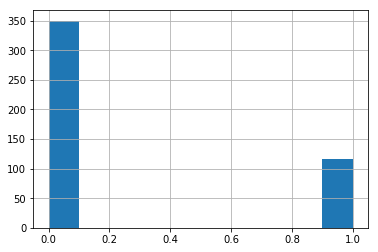

In [25]:
# see the dist. of labels: unbalanced labels!
X_with_label.groupby('ITEST_id').isSTEM.mean().hist()

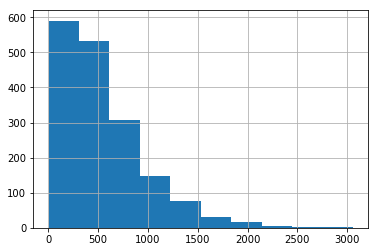

In [3]:
# number of actions for each student before summarization
pre.raw_dataset.groupby("ITEST_id").size().hist()